
# Use pixel graphs to find an object's geodesic center

In various image analysis situations, it is useful to think of the pixels of an
image, or of a region of an image, as a network or graph, in which each pixel
is connected to its neighbors (with or without diagonals). One such situation
is finding the *geodesic center* of an object, which is the point closest to
all other points *if you are only allowed to travel on the pixels of the
object*, rather than in a straight line. This point is the one with maximal
*closeness centrality* [1]_ in the network.

In this example, we create such a *pixel graph* of a skeleton and find
the central pixel of that skeleton. This demonstrates its utility in contrast
with the centroid (also known as the center of mass) which may actually fall
outside the object.

## References
.. [1] Linton C. Freeman: Centrality in networks: I.
       Conceptual clarification. Social Networks 1:215-239, 1979.
       :DOI:`10.1016/0378-8733(78)90021-7`


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import color, data, filters, graph, measure, morphology

We start by loading the data: an image of a human retina.



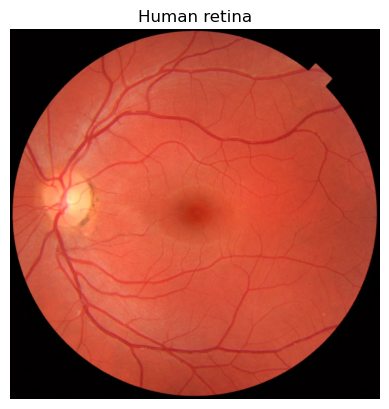

In [2]:
retina_source = data.retina()

_, ax = plt.subplots()
ax.imshow(retina_source)
ax.set_axis_off()
_ = ax.set_title('Human retina')

We convert the image to grayscale, then use the
`Sato vesselness filter <skimage.filters.sato>` to better distinguish the
main vessels in the image.



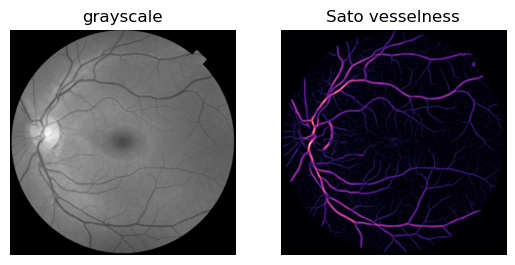

In [3]:
retina = color.rgb2gray(retina_source)
t0, t1 = filters.threshold_multiotsu(retina, classes=3)
mask = (retina > t0)
vessels = filters.sato(retina, sigmas=range(1, 10)) * mask

_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(retina, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Sato vesselness')

Based on the observed vesselness values, we use
`hysteresis thresholding <skimage.filters.apply_hysteresis_threshold>` to
define the main vessels.



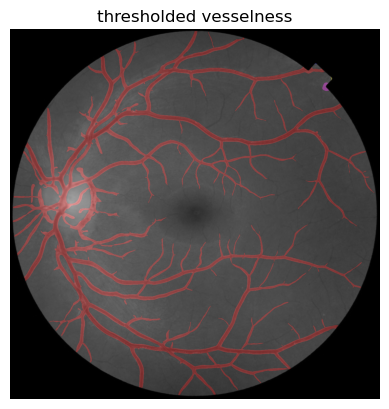

In [4]:
thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)
labeled = ndi.label(thresholded)[0]

_, ax = plt.subplots()
ax.imshow(color.label2rgb(labeled, retina))
ax.set_axis_off()
_ = ax.set_title('thresholded vesselness')

Finally, we can `skeletonize <skimage.morphology.skeletonize>` this label
image and use that as the basis to find the
`central pixel <skimage.graph.central_pixel>` in that skeleton. Compare that
to the position of the centroid!



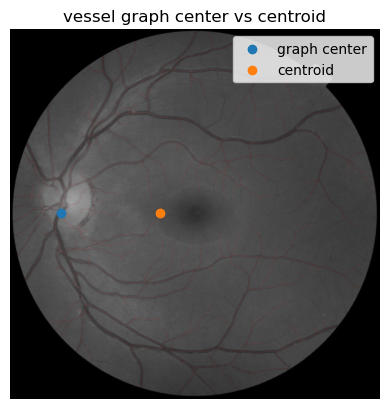

In [5]:
largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
binary = labeled == largest_nonzero_label
skeleton = morphology.skeletonize(binary)
g, nodes = graph.pixel_graph(skeleton, connectivity=2)
px, distances = graph.central_pixel(
        g, nodes=nodes, shape=skeleton.shape, partition_size=100
        )

centroid = measure.centroid(labeled > 0)

_, ax = plt.subplots()
ax.imshow(color.label2rgb(skeleton, retina))
ax.scatter(px[1], px[0], label='graph center')
ax.scatter(centroid[1], centroid[0], label='centroid')
ax.legend()
ax.set_axis_off()
ax.set_title('vessel graph center vs centroid')

plt.show()